In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import json
from sklearn import preprocessing
from sklearn import model_selection
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from Data_mining import data_mining

In [64]:
#Data mining process
#df=data_mining("ETH-USDT", "5m", "2021/01/01", "2023/08/11")
#df.to_csv("ETH-USDT_5m.csv")
#df

In [3]:
df=pd.read_csv('./ETH-USDT_5m.csv')
df=df.set_index(['time'])
df

,open,close,high,low,volume
time,,,,,
2021-01-01 00:00:00,738.52,739.09,739.09,737.71,9102.55
2021-01-01 00:05:00,739.09,739.65,740.49,738.83,9580.63
2021-01-01 00:10:00,739.65,739.18,740.11,738.98,8915.66
2021-01-01 00:15:00,739.18,739.07,739.87,738.75,8787.57
2021-01-01 00:20:00,739.10,741.32,741.51,738.94,9586.71
...,...,...,...,...,...
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23
2023-08-10 23:45:00,1850.67,1851.03,1851.54,1850.67,1229.89


In [4]:
pd.date_range(start='2021-01-01 00:00:00', end='2023-08-03 23:55:00').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

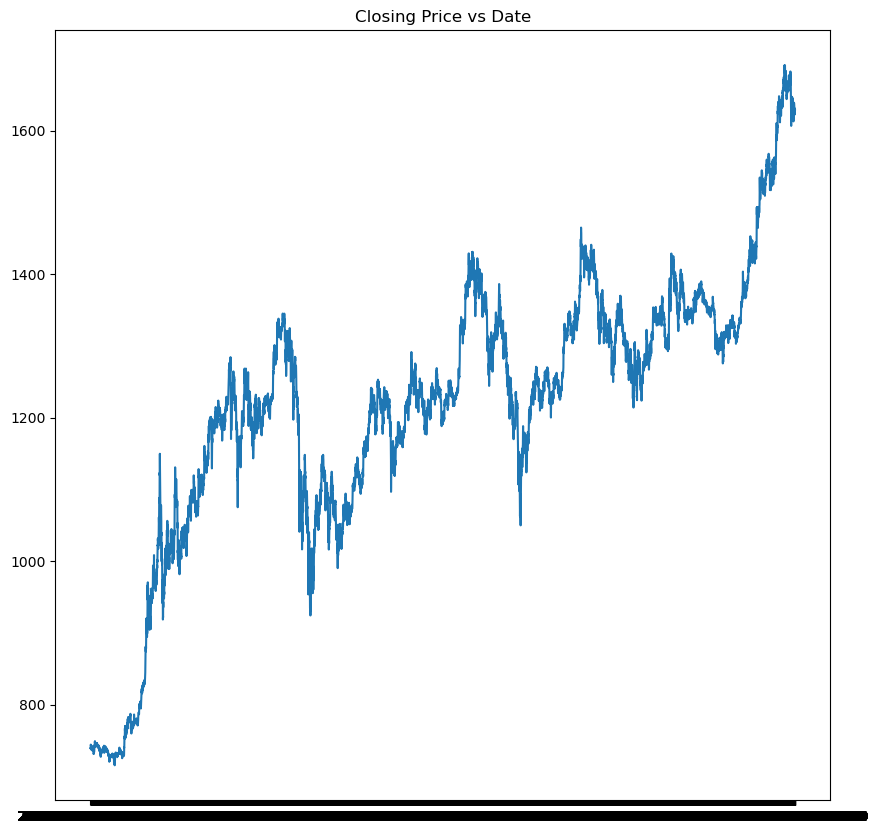

In [5]:
plt.figure(figsize=(10,10))
plt.title("Closing Price vs Date")
plt.plot(df['close'][0:10000])
plt.show()

In [6]:
df['tomorrow']=df['close'].shift(-1)
df['target']=(df['tomorrow'] > df['close']).astype(int)

In [7]:
dataset=df.iloc[:, 0:df.shape[1]].values
dataset.shape

(274459, 7)

In [8]:
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset_scaled=scaler.fit_transform(dataset)

In [9]:
dataset_scaled.shape

(274459, 7)

In [10]:
dataset_scaled[:, 6]

array([1., 0., 0., ..., 0., 1., 0.])

In [11]:
training_set, test_and_validation_set=model_selection.train_test_split(dataset_scaled, test_size=0.01, shuffle=False)
training_set.shape

(271714, 7)

In [12]:
test_and_validation_set.shape

(2745, 7)

In [13]:
validation_set, test_set=model_selection.train_test_split(test_and_validation_set, test_size=0.5, shuffle=False)
print(validation_set.shape)
print(test_set.shape)

(1372, 7)
(1373, 7)


In [14]:
X_train=[]
y_train=[]
for i in range(12, len(training_set)):
    X_train.append(training_set[i-12:i, :])
    y_train.append(training_set[i, 6])
X_train, y_train=np.array(X_train), np.array(y_train)

In [15]:
X_train=np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], df.shape[1]))
X_train.shape

(271702, 12, 7)

In [16]:
y_train.shape

(271702,)

In [17]:
X_validation=[]
y_validation=[]
for i in range(12, len(validation_set)):
    X_validation.append(validation_set[i-12:i, :])
    y_validation.append(validation_set[i, 6])
X_validation, y_validation=np.array(X_validation), np.array(y_validation)
X_validation=np.reshape(X_validation, newshape=(X_validation.shape[0], X_validation.shape[1], df.shape[1]))
X_validation.shape

(1360, 12, 7)

In [20]:
y_validation.shape

(1360,)

In [24]:
def create_lstm_model(neurons, dropout_rate):
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True, input_shape=(X_validation.shape[1], X_validation.shape[2])))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=False))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(units=1))
    
    return model

neurons=[40,50,60,70]
dropout_rate=[0.2, 0.3, 0.4, 0.5]
epochs=[75,100]
batch_size=[20,30,40]
param_grid=dict(model__neurons=neurons, model__dropout_rate=dropout_rate, epochs=epochs, batch_size=batch_size)
tuning_model=KerasClassifier(model=create_lstm_model, loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], verbose=0)
grid=model_selection.GridSearchCV(estimator=tuning_model, param_grid=param_grid, n_jobs=None, cv=3, verbose=0)
grid_result=grid.fit(X_validation, y_validation)

In [65]:
grid_result.best_params_

{'batch_size': 40,
 'epochs': 75,
 'model__dropout_rate': 0.2,
 'model__neurons': 60,
 'best_score': 0.5235240345810116}

In [66]:
grid_result.best_score_

0.5235240345810116

In [67]:
grid_results_lstm_classification=grid_result.best_params_

In [68]:
grid_results_lstm_classification

{'batch_size': 40,
 'epochs': 75,
 'model__dropout_rate': 0.2,
 'model__neurons': 60,
 'best_score': 0.5235240345810116}

In [69]:
with open('./LSTM Model/LSTM Classification/GridSearch_Results_LSTM_Classification.txt', 'w') as text_file:
     text_file.write(json.dumps(grid_results_lstm_classification))

In [38]:
lstm_model=tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12, 50)            11600     
                                                                 
 dropout_12 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 12, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 12, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 12, 50)           

In [ ]:
lstm_model.fit(X_train, y_train, epochs=100, batch_size=20)

Epoch 1/100
 1007/13586 [=>............................] - ETA: 4:33 - loss: 0.8094 - accuracy: 0.4988

In [24]:
#training_loss_values_lstm=lstm_model.history.history['loss']

In [25]:
#test_inputs=test_and_validation_set[len(test_and_validation_set)-len(test_set):]

In [26]:
#X_test=[]
#y_test=[]
#for i in range(12, len(test_inputs)):
    #X_test.append(test_inputs[i-12:i, :])
    #y_test.append(test_inputs[i, 1])
#X_test, y_test=np.array(X_test), np.array(y_test)
#X_test=np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], X_test.shape[2]))
#X_test.shape

In [27]:
#predicted_close_prices=lstm_model.predict(X_test)

In [28]:
#score=lstm_model.evaluate(X_test, y_test)

In [29]:
#lstm_model.save('./LSTM Model/LSTM_model.h5')
#lstm_model.save_weights('./LSTM Model/LSTM_model_weights')
#np.savetxt('./LSTM Model/TrainingLossValues.txt', training_loss_values_lstm)

In [30]:
training_loss_values_lstm=np.loadtxt('./LSTM Model/TrainingLossValues.txt')
lstm_model=tf.keras.models.load_model('./LSTM Model/LSTM_model.h5')

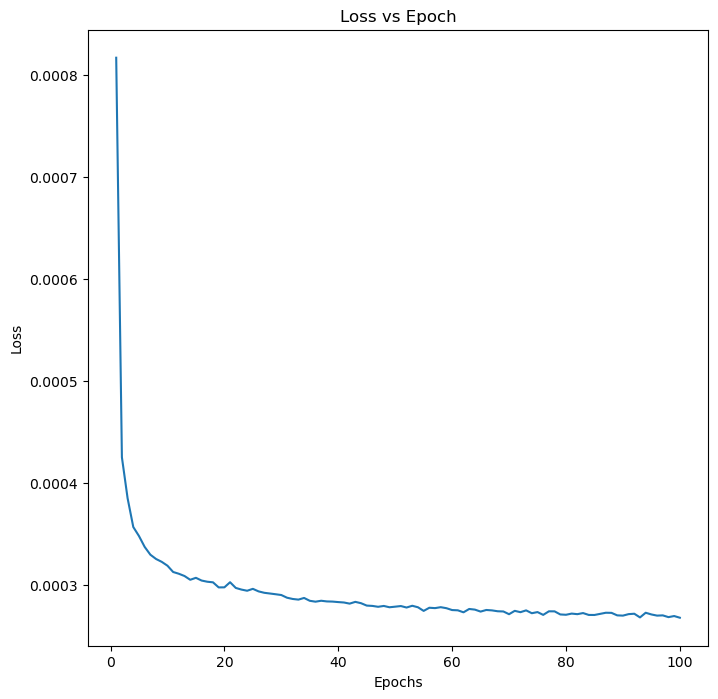

In [31]:
plt.figure(figsize=(8,8))
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(1, 101), training_loss_values_lstm)
plt.show()

In [32]:
test_inputs=test_and_validation_set[len(test_and_validation_set)-len(test_set):]
test_inputs.shape

(2745, 5)

In [33]:
X_test=[]
y_test=[]
for i in range(12, len(test_inputs)):
    X_test.append(test_inputs[i-12:i, :])
    y_test.append(test_inputs[i, 1])
    
X_test, y_test=np.array(X_test), np.array(y_test)
X_test=np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_test.shape

(2733,)

In [34]:
score=lstm_model.evaluate(X_test, y_test)

86/86 [==============================] - 6s 13ms/step - loss: 1.3950e-06


In [35]:
predicted_close_prices=lstm_model.predict(X_test)

86/86 [==============================] - 3s 11ms/step


In [36]:
predicted_close_prices.shape

(2733, 1)

In [37]:
prediction_copies_array = np.repeat(predicted_close_prices,5, axis=-1)
predicted_close_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predicted_close_prices),5)))[:,0]

In [38]:
y_test_copy = np.repeat(y_test,5, axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copy,(len(y_test),5)))[:,0]

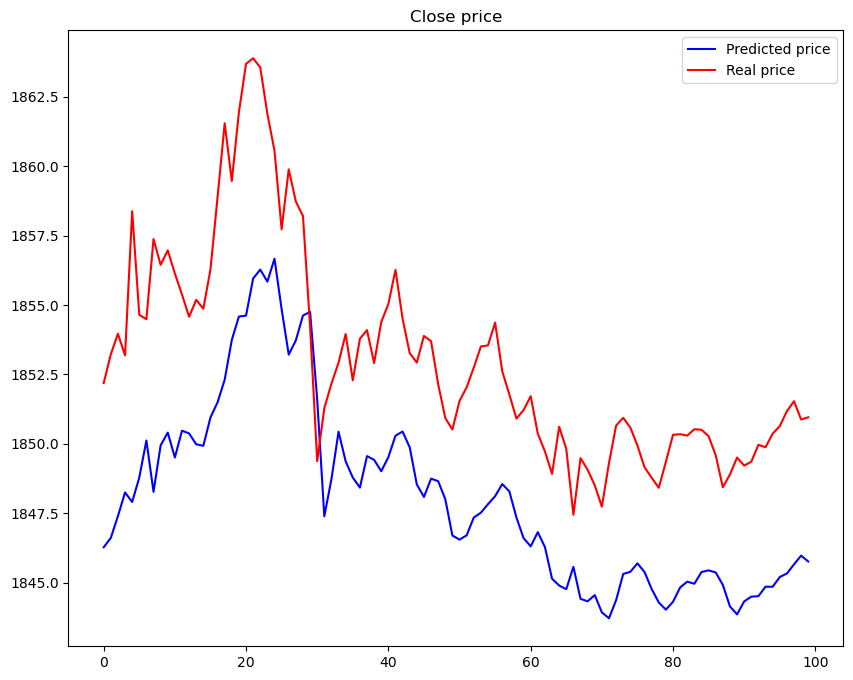

In [39]:
plt.figure(figsize=(10,8))
plt.plot(predicted_close_prices[len(predicted_close_prices)-100:len(predicted_close_prices)], color='blue', label='Predicted price')
plt.plot(y_test[len(y_test)-100:len(y_test)], color='red', label='Real price')
plt.title("Close price")
plt.legend()
plt.show()

### Building Random Forest Model

In [42]:
dataset_rf=df.copy()

In [48]:
dataset_rf['tomorrow']=dataset_rf['close'].shift(-1)

In [55]:
dataset_rf['target']=(dataset_rf['tomorrow'] > dataset_rf['close']).astype(int)

In [57]:
dataset_rf

,open,close,high,low,volume,tomorrow,target
time,,,,,,,
2021-01-01 00:00:00,738.52,739.09,739.09,737.71,9102.55,739.65,1
2021-01-01 00:05:00,739.09,739.65,740.49,738.83,9580.63,739.18,0
2021-01-01 00:10:00,739.65,739.18,740.11,738.98,8915.66,739.07,0
2021-01-01 00:15:00,739.18,739.07,739.87,738.75,8787.57,741.32,1
2021-01-01 00:20:00,739.10,741.32,741.51,738.94,9586.71,744.09,1
...,...,...,...,...,...,...,...
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1850.67,1
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23,1851.03,1
2023-08-10 23:45:00,1850.67,1851.03,1851.54,1850.67,1229.89,1850.37,0


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [60]:
randomForest_model=RandomForestClassifier(n_estimators=150, min_samples_split=100, random_state=1)

In [62]:
trainset_rf=dataset_rf.iloc[:-100]
testset_rf=dataset_rf.iloc[-100:]
predictors=['close', 'open', 'low', 'high', 'volume']

In [63]:
randomForest_model.fit(trainset_rf[predictors], trainset_rf['target'])

RandomForestClassifier(min_samples_split=100, n_estimators=150, random_state=1)

In [67]:
predictions=randomForest_model.predict(testset_rf[predictors])
predictions=pd.Series(predictions, index=testset_rf.index)

In [68]:
precision_score(testset_rf['target'], predictions)

0.49230769230769234

In [70]:
results_rf=pd.concat([testset_rf['target'], predictions], axis=1)

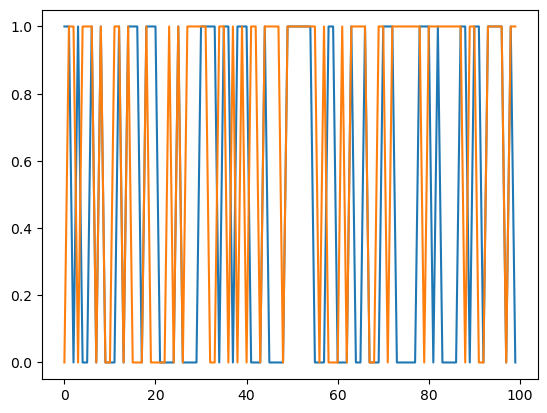

In [74]:
plt.plot(range(0,100) ,results_rf)
plt.show()